In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Lambda
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [ ]:
train_folder = "/content/drive/MyDrive/skin_cancer/train"
test_folder = "/content/drive/MyDrive/skin_cancer/test"

In [ ]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))

count_files(os.path.join(test_folder))

There are 310 files in malignant
There are 360 files in benign


In [ ]:
count_files(os.path.join(train_folder))

There are 1197 files in malignant
There are 1440 files in benign


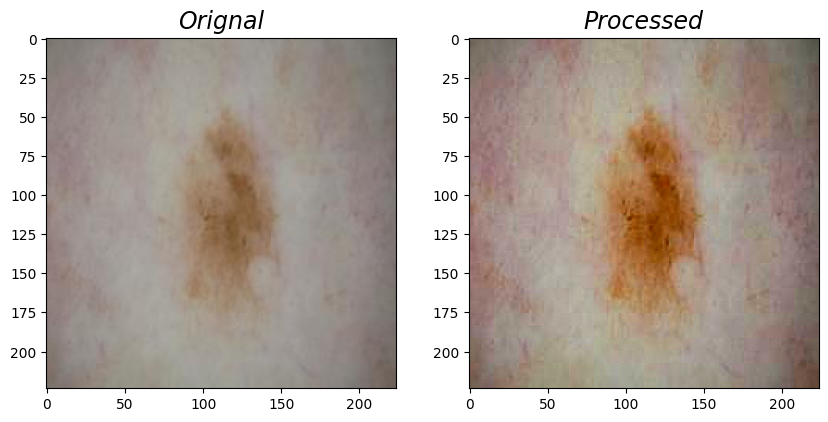

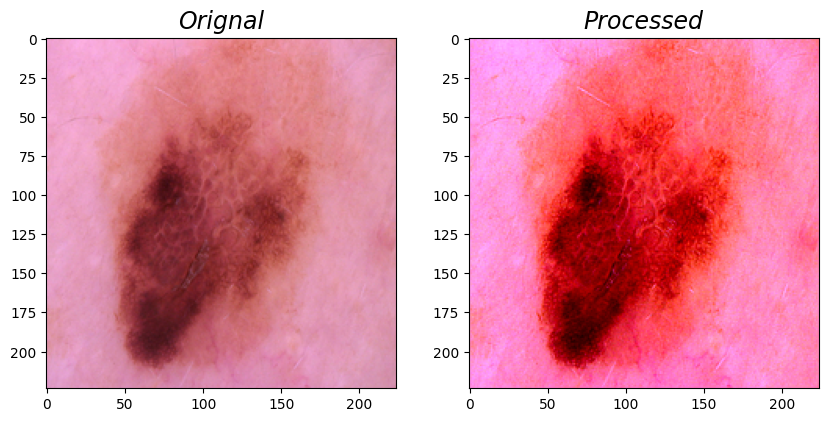

In [ ]:
image_folder="malignant"
number_of_images=2

def Preprocess():
    j=1
    for i in range(number_of_images):

        folder = os.path.join(test_folder,image_folder)
        a=random.choice(os.listdir(folder))

        image=Image.open(os.path.join(folder,a))
        image_duplicate=image.copy()
        plt.figure(figsize=(10,10))

        plt.subplot(number_of_images,2,j)
        plt.title(label='Orignal', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image)
        j+=1

        image1=ImageEnhance.Color(image_duplicate).enhance(1.35)
        image1=ImageEnhance.Contrast(image1).enhance(1.45)
        image1=ImageEnhance.Sharpness(image1).enhance(2.5)

        plt.subplot(number_of_images,2,j)
        plt.title(label='Processed', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image1)
        j+=1

Preprocess()

In [ ]:
n_cat =2

batch_size = 48
batch_size_predict = 128
input_shape = (299,299)

In [ ]:
x_model = Xception(input_shape=list(input_shape) + [3],
                   weights='imagenet',
                   include_top=False)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in x_model.layers:
    layer.trainable = True

for layer in x_model.layers[:85]:
    layer.trainable = False

x_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 11,630,312 (44.37 MB)

 Non-trainable params: 9,231,168 (35.21 MB)

In [ ]:
gm_exp = tf.Variable(3., dtype=tf.float32)
def generalized_mean_pool_2d(X):
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)),
                           axis=[1,2],
                           keepdims=False)+1.e-8)**(1./gm_exp)
    return pool
X_feat = Input(x_model.output_shape[1:])

lambda_layer = Lambda(generalized_mean_pool_2d)
lambda_layer.trainable_weights.extend([gm_exp])
X = lambda_layer(X_feat)
X = Dropout(0.05)(X)
X = Activation('relu')(X)
X = Dense(n_cat, activation='softmax')(X)

top_model = Model(inputs=X_feat, outputs=X)
top_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 10, 10, 2048)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,098 (16.01 KB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_image = Input(list(input_shape) + [3])

X_f = x_model(X_image)
X_f = top_model(X_f)

model = Model(inputs=X_image, outputs=X_f)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,865,578 (79.60 MB)

 Trainable params: 11,634,410 (44.38 MB)

 Non-trainable params: 9,231,168 (35.21 MB)

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [ ]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (299, 299),
    batch_size = 48,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder,
    target_size = (299, 299),
    batch_size = 48,
    class_mode = 'categorical')

Found 2637 images belonging to 2 classes.
Found 670 images belonging to 2 classes.


In [ ]:
Model = model.fit(
  training_set,
  validation_data=test_set,
  epochs=20
)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 567s 9s/step - accuracy: 0.7585 - loss: 0.5075 - val_accuracy: 0.8522 - val_loss: 0.3477
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8905 - loss: 0.2599 - val_accuracy: 0.8597 - val_loss: 0.3310
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9168 - loss: 0.2005 - val_accuracy: 0.8418 - val_loss: 0.4082
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9187 - loss: 0.1818 - val_accuracy: 0.8627 - val_loss: 0.4093
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9476 - loss: 0.1388 - val_accuracy: 0.8582 - val_loss: 0.3685
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9506 - loss: 0.1295 - val_accuracy: 0.8507 - val_loss: 0.8324
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9494 - loss: 0.1315 - val_accuracy: 0.8716 - val_loss: 0.4062
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9660 - loss: 0.0866 - val_accuracy: 0.8687 - val_lo

In [ ]:
model.save('/content/drive/MyDrive/skin_cancer/xception_Model.keras')
model.save('/content/drive/MyDrive/skin_cancer/xception_model.h5')

In [ ]:
score = model.evaluate(test_set)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 417ms/step - accuracy: 0.8916 - loss: 0.5606
Test loss: 0.7046387791633606
Test accuracy: 0.8805969953536987


In [ ]:

import numpy as np
from sklearn.metrics import classification_report
xception_y_pred = (model.predict(x_test) > 0.5).astype("int32")

y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

y_true = test_set.classes

# Print classification report
print(classification_report(y_true, y_pred))


14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 507ms/step
              precision    recall  f1-score   support

           0       0.53      0.56      0.54       360
           1       0.45      0.42      0.44       310

    accuracy                           0.50       670
   macro avg       0.49      0.49      0.49       670
weighted avg       0.49      0.50      0.49       670



In [ ]:
category={
    0:'benign',1:'malignant'
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(299, 299))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.

    prediction = model.predict(img_processed)
    index = np.argmax(prediction)

    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)

def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1

    true=filedir.split('/')[-1]

    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))

    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(299, 299))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0)
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)

        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


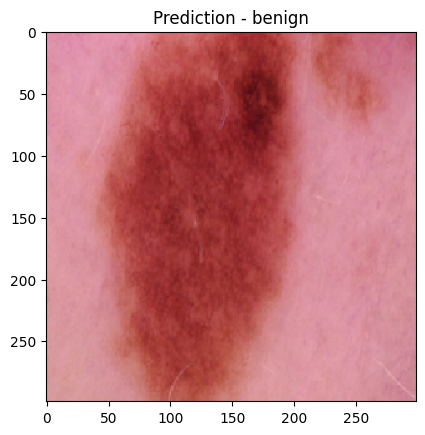

In [ ]:
predict_image('/content/drive/MyDrive/skin_cancer/test/benign/1003.jpg',model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


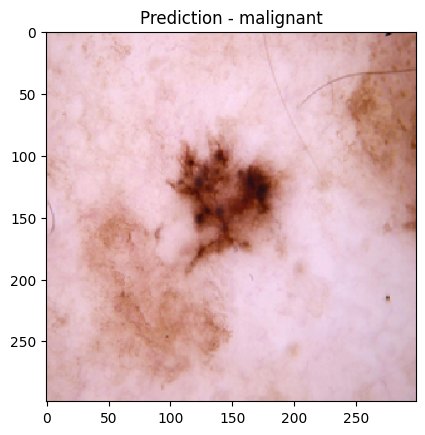

In [ ]:
predict_image('/content/drive/MyDrive/skin_cancer/test/malignant/1003.jpg',model)

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report

# Function to predict and get real and predicted labels
def labels_confusion_matrix(test_folder):
    folder_path = test_folder
    mapping = {}

    # Create a mapping for classes
    for i, j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j] = i

    real = []
    predicted = []

    # Iterate through each class folder
    for i in os.listdir(folder_path):
        true_label = mapping[i]  # Get the label index for the class

        # Iterate through images in the class folder
        for j in os.listdir(os.path.join(folder_path, i)):
            img_path = os.path.join(folder_path, i, j)
            img = image.load_img(img_path, target_size=(299, 299))
            img_array = image.img_to_array(img)
            img_processed = np.expand_dims(img_array, axis=0)
            img_processed /= 255.0

            # Predict the class of the image
            prediction = model.predict(img_processed)
            predicted_label = np.argmax(prediction)

            # Append true and predicted labels
            predicted.append(predicted_label)
            real.append(true_label)

    return real, predicted

# Function to display confusion matrix
def print_confusion_matrix(real, predicted):
    cmap = "OrRd"
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    cm_plot_labels = [0, 1]  # Assuming binary classification

    # Plot confusion matrix heatmap
    df_cm = pd.DataFrame(cm, index=cm_plot_labels, columns=cm_plot_labels)
    sns.set(font_scale=1.2)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap=cmap)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

# Function to print classification report
def print_classification_report(real, predicted):
    report = classification_report(y_true=real, y_pred=predicted, target_names=['Benign', 'Malignant'])
    print("Classification Report:\n")
    print(report)


In [ ]:
# Run predictions and evaluate model
y_true, y_pred = labels_confusion_matrix(test_folder)
print_classification_report(y_true, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

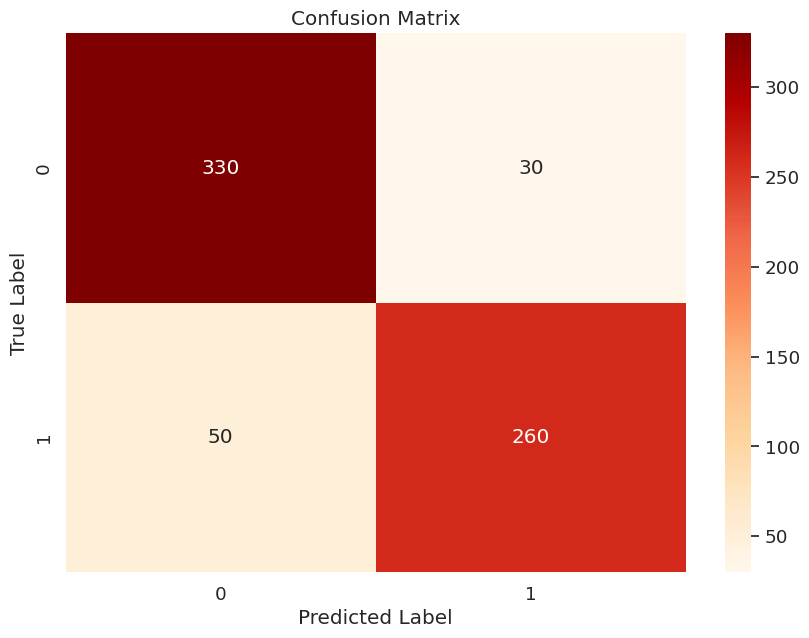

In [ ]:
print_confusion_matrix(y_true, y_pred)